In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
DEVICE = "cuda" # or "cpu"

# Load the MNIST data

In [2]:
#Download the datasets
dataset_train = torchvision.datasets.MNIST('../data', train=True, download=True,transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('../data', train=False, download=True,transform=torchvision.transforms.ToTensor())
# For normalization, get mean and std of the training dataset
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train))
data = next(iter(train_loader))[0]
mean, std = data.mean().item(), data.std().item()
print("Mean pixel is",mean," and std is",std)

# Now we can load the dataset with normalizing transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mean,),(std,))
])
dataset_train.transform = transform
dataset_test.transform = transform

Mean pixel is 0.13066047430038452  and std is 0.30810782313346863


In [3]:
## Split the training set and the test set into two equal sized parts

# Note: If you want less, use (500,500,30000-500) and use third dummy dataset
dataset_train_A, dataset_train_B = torch.utils.data.random_split(dataset_train,(30000,30000))
# dataset_test is common to both tasks

# Datasets now ready
dataset_train_A_loader = torch.utils.data.DataLoader(dataset_train_A, batch_size = 256)
dataset_train_B_loader = torch.utils.data.DataLoader(dataset_train_B, batch_size = 256)
dataset_test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = 256)

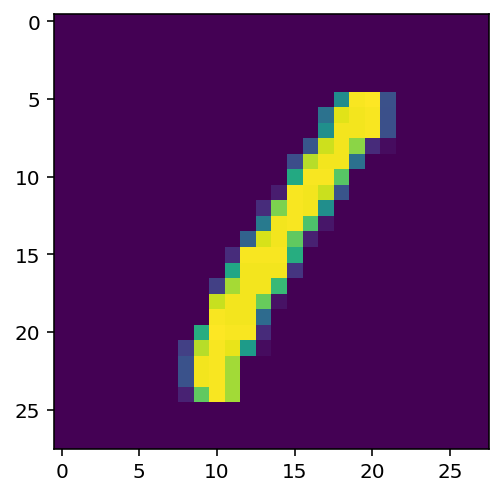

In [5]:
plt.imshow(dataset_train[3][0].reshape(28,28)); # plt.imshow does a min-max normalization, so it always looks the same

# Define the model and the training process

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [56]:
def train(model, train_loader, optimizer, epoch):
    model.train() # Change into training mode (matters for dropout, at least)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    # return the latest loss
    return loss.item()

In [57]:
def test(model, test_loader):
    model.eval() #Change to evalution mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output=model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum of the batch loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item() # Number of correct guesses
    test_loss /= len(test_loader.dataset) #Mean loss (divided by the size of the whole test set)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    # Return both loss value and test accuracy
    return test_loss, correct / len(test_loader.dataset)

In [58]:
# Train the model A for 10 epochs!
modelA = Net().to(DEVICE)
optimizerA = optim.Adam(modelA.parameters())
for epoch in range(10):
    train(modelA, dataset_train_A_loader, optimizerA, epoch)
    with torch.no_grad():
        test(modelA, dataset_test_loader)

Train Epoch: 0 [0/30000 (0%)]	Loss: 2.304003
Train Epoch: 0 [2560/30000 (8%)]	Loss: 0.909584
Train Epoch: 0 [5120/30000 (17%)]	Loss: 0.606593
Train Epoch: 0 [7680/30000 (25%)]	Loss: 0.512732
Train Epoch: 0 [10240/30000 (34%)]	Loss: 0.335289
Train Epoch: 0 [12800/30000 (42%)]	Loss: 0.282091
Train Epoch: 0 [15360/30000 (51%)]	Loss: 0.360612
Train Epoch: 0 [17920/30000 (59%)]	Loss: 0.242235
Train Epoch: 0 [20480/30000 (68%)]	Loss: 0.164000
Train Epoch: 0 [23040/30000 (76%)]	Loss: 0.150184
Train Epoch: 0 [25600/30000 (85%)]	Loss: 0.175307
Train Epoch: 0 [28160/30000 (93%)]	Loss: 0.181510

Test set: Average loss: 0.0835, Accuracy: 9735/10000 (97%)

Train Epoch: 1 [0/30000 (0%)]	Loss: 0.179366
Train Epoch: 1 [2560/30000 (8%)]	Loss: 0.130831
Train Epoch: 1 [5120/30000 (17%)]	Loss: 0.165131
Train Epoch: 1 [7680/30000 (25%)]	Loss: 0.167252
Train Epoch: 1 [10240/30000 (34%)]	Loss: 0.130570
Train Epoch: 1 [12800/30000 (42%)]	Loss: 0.140507
Train Epoch: 1 [15360/30000 (51%)]	Loss: 0.171461
Train E

In [59]:
# Train the model B for 10 epochs!
modelB = Net().to(DEVICE)
optimizerB = optim.Adam(modelB.parameters())
for epoch in range(10):
    train(modelB, dataset_train_B_loader, optimizerB, epoch)
    with torch.no_grad():
        test(modelB, dataset_test_loader)

Train Epoch: 0 [0/30000 (0%)]	Loss: 2.312920
Train Epoch: 0 [2560/30000 (8%)]	Loss: 0.833830
Train Epoch: 0 [5120/30000 (17%)]	Loss: 0.451679
Train Epoch: 0 [7680/30000 (25%)]	Loss: 0.351372
Train Epoch: 0 [10240/30000 (34%)]	Loss: 0.446002
Train Epoch: 0 [12800/30000 (42%)]	Loss: 0.379788
Train Epoch: 0 [15360/30000 (51%)]	Loss: 0.264422
Train Epoch: 0 [17920/30000 (59%)]	Loss: 0.253296
Train Epoch: 0 [20480/30000 (68%)]	Loss: 0.206405
Train Epoch: 0 [23040/30000 (76%)]	Loss: 0.341112
Train Epoch: 0 [25600/30000 (85%)]	Loss: 0.104567
Train Epoch: 0 [28160/30000 (93%)]	Loss: 0.115281

Test set: Average loss: 0.0925, Accuracy: 9718/10000 (97%)

Train Epoch: 1 [0/30000 (0%)]	Loss: 0.207057
Train Epoch: 1 [2560/30000 (8%)]	Loss: 0.173924
Train Epoch: 1 [5120/30000 (17%)]	Loss: 0.102063
Train Epoch: 1 [7680/30000 (25%)]	Loss: 0.076967
Train Epoch: 1 [10240/30000 (34%)]	Loss: 0.154473
Train Epoch: 1 [12800/30000 (42%)]	Loss: 0.119760
Train Epoch: 1 [15360/30000 (51%)]	Loss: 0.126123
Train E

# Plot the training loss on the line between solutions

In [45]:
theta1 = torch.nn.utils.parameters_to_vector(modelA.parameters())
theta2 = torch.nn.utils.parameters_to_vector(modelB.parameters())

In [46]:
alfas = np.linspace(-0.3,1.3,30)
losses_and_accuracies = []
for alfa in alfas:
    meantensor = theta1*(1-alfa) + alfa*theta2
    modelMean = Net()
    torch.nn.utils.vector_to_parameters(meantensor, modelMean.parameters())
    with torch.no_grad():
        losses_and_accuracies.append(test(modelMean,dataset_test_loader))


Test set: Average loss: 0.1403, Accuracy: 9861/10000 (99%)


Test set: Average loss: 0.1077, Accuracy: 9861/10000 (99%)


Test set: Average loss: 0.0829, Accuracy: 9865/10000 (99%)


Test set: Average loss: 0.0644, Accuracy: 9869/10000 (99%)


Test set: Average loss: 0.0508, Accuracy: 9878/10000 (99%)


Test set: Average loss: 0.0414, Accuracy: 9878/10000 (99%)


Test set: Average loss: 0.0371, Accuracy: 9874/10000 (99%)


Test set: Average loss: 0.0407, Accuracy: 9870/10000 (99%)


Test set: Average loss: 0.0636, Accuracy: 9871/10000 (99%)


Test set: Average loss: 0.1411, Accuracy: 9851/10000 (99%)


Test set: Average loss: 0.3422, Accuracy: 9819/10000 (98%)


Test set: Average loss: 0.6962, Accuracy: 9738/10000 (97%)


Test set: Average loss: 1.0975, Accuracy: 9590/10000 (96%)


Test set: Average loss: 1.4050, Accuracy: 9303/10000 (93%)


Test set: Average loss: 1.5613, Accuracy: 8986/10000 (90%)


Test set: Average loss: 1.5484, Accuracy: 9098/10000 (91%)


Test set: Average loss:

In [47]:
losses = list(zip(*losses_and_accuracies))[0]
accuracies = list(zip(*losses_and_accuracies))[1]

In [48]:
plt.rc('text', usetex=True)

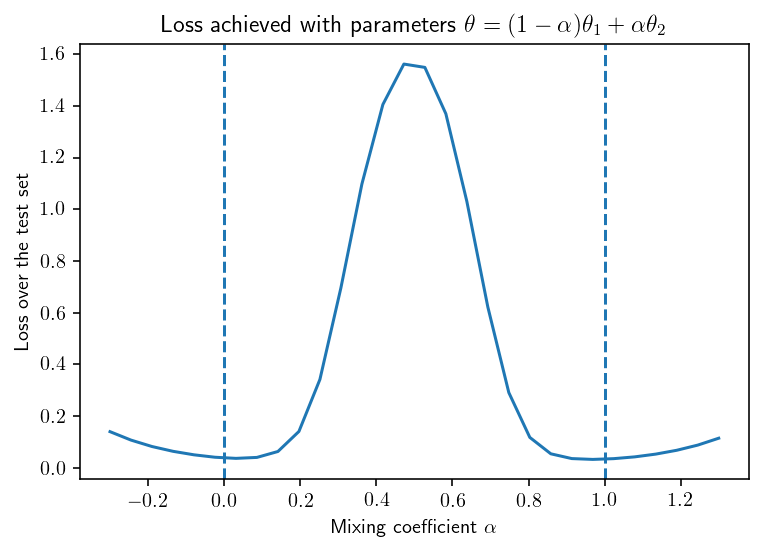

In [49]:
plt.figure();
plt.plot(alfas,losses);
plt.title(r"Loss achieved with parameters $\theta=(1-\alpha)\theta_1 + \alpha \theta_2$")
plt.ylabel("Loss over the test set");
plt.xlabel(r"Mixing coefficient $\alpha$");
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');

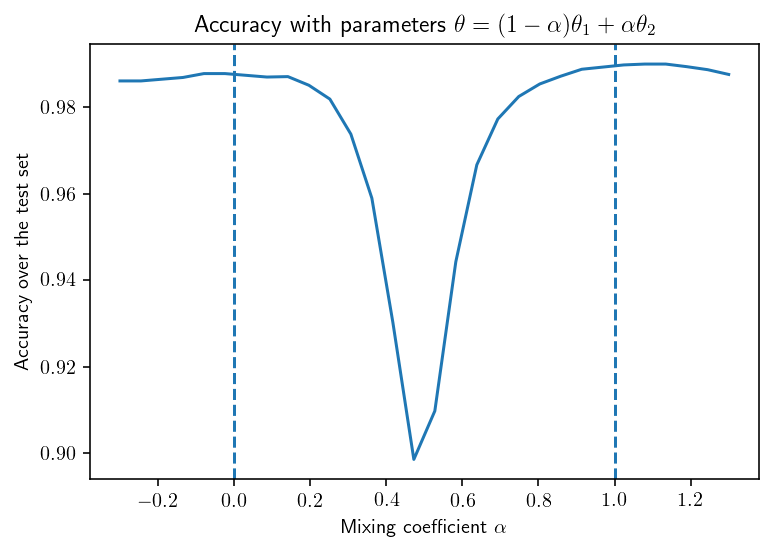

In [51]:
plt.figure()
plt.plot(alfas,accuracies);
plt.title(r"Accuracy with parameters $\theta=(1-\alpha)\theta_1 + \alpha \theta_2$")
plt.ylabel("Accuracy over the test set");
plt.xlabel(r"Mixing coefficient $\alpha$");
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');

# What about when using common initalization?

In [60]:
modelA = Net().to(DEVICE)
modelB = Net().to(DEVICE)
#Copy the initalization of A into B

# old way:
#parametersA = torch.nn.utils.parameters_to_vector(modelA.parameters())
#torch.nn.utils.vector_to_parameters(parametersA, modelB.parameters())

# new way:
modelB.load_state_dict(modelA.state_dict())

# Train A for 5 epochs
optimizerA = optim.Adam(modelA.parameters())
for epoch in range(10):
    train(modelA, dataset_train_A_loader, optimizerA, epoch)
    with torch.no_grad():
        test(modelA, dataset_test_loader)
# Train B for 5 epochs
optimizerB = optim.Adam(modelB.parameters())
for epoch in range(10):
    train(modelB, dataset_train_B_loader, optimizerB, epoch)
    with torch.no_grad():
        test(modelB, dataset_test_loader)

Train Epoch: 0 [0/30000 (0%)]	Loss: 2.304216
Train Epoch: 0 [2560/30000 (8%)]	Loss: 0.807523
Train Epoch: 0 [5120/30000 (17%)]	Loss: 0.672747
Train Epoch: 0 [7680/30000 (25%)]	Loss: 0.379314
Train Epoch: 0 [10240/30000 (34%)]	Loss: 0.379082
Train Epoch: 0 [12800/30000 (42%)]	Loss: 0.218081
Train Epoch: 0 [15360/30000 (51%)]	Loss: 0.225931
Train Epoch: 0 [17920/30000 (59%)]	Loss: 0.206252
Train Epoch: 0 [20480/30000 (68%)]	Loss: 0.146857
Train Epoch: 0 [23040/30000 (76%)]	Loss: 0.177332
Train Epoch: 0 [25600/30000 (85%)]	Loss: 0.186936
Train Epoch: 0 [28160/30000 (93%)]	Loss: 0.123665

Test set: Average loss: 0.0838, Accuracy: 9744/10000 (97%)

Train Epoch: 1 [0/30000 (0%)]	Loss: 0.110352
Train Epoch: 1 [2560/30000 (8%)]	Loss: 0.176547
Train Epoch: 1 [5120/30000 (17%)]	Loss: 0.190042
Train Epoch: 1 [7680/30000 (25%)]	Loss: 0.154573
Train Epoch: 1 [10240/30000 (34%)]	Loss: 0.211979
Train Epoch: 1 [12800/30000 (42%)]	Loss: 0.087499
Train Epoch: 1 [15360/30000 (51%)]	Loss: 0.148708
Train E

Train Epoch: 2 [20480/30000 (68%)]	Loss: 0.074468
Train Epoch: 2 [23040/30000 (76%)]	Loss: 0.076607
Train Epoch: 2 [25600/30000 (85%)]	Loss: 0.087478
Train Epoch: 2 [28160/30000 (93%)]	Loss: 0.056214

Test set: Average loss: 0.0490, Accuracy: 9842/10000 (98%)

Train Epoch: 3 [0/30000 (0%)]	Loss: 0.107255
Train Epoch: 3 [2560/30000 (8%)]	Loss: 0.054545
Train Epoch: 3 [5120/30000 (17%)]	Loss: 0.131918
Train Epoch: 3 [7680/30000 (25%)]	Loss: 0.074916
Train Epoch: 3 [10240/30000 (34%)]	Loss: 0.100764
Train Epoch: 3 [12800/30000 (42%)]	Loss: 0.053129
Train Epoch: 3 [15360/30000 (51%)]	Loss: 0.029901
Train Epoch: 3 [17920/30000 (59%)]	Loss: 0.073950
Train Epoch: 3 [20480/30000 (68%)]	Loss: 0.070716
Train Epoch: 3 [23040/30000 (76%)]	Loss: 0.065451
Train Epoch: 3 [25600/30000 (85%)]	Loss: 0.055967
Train Epoch: 3 [28160/30000 (93%)]	Loss: 0.066697

Test set: Average loss: 0.0439, Accuracy: 9852/10000 (99%)

Train Epoch: 4 [0/30000 (0%)]	Loss: 0.060752
Train Epoch: 4 [2560/30000 (8%)]	Loss: 0.0

In [61]:
theta1 = torch.nn.utils.parameters_to_vector(modelA.parameters())
theta2 = torch.nn.utils.parameters_to_vector(modelB.parameters())

alfas = np.linspace(-0.3,1.3,30)
losses_and_accuracies = []
for alfa in alfas:
    meantensor = theta1*(1-alfa) + alfa*theta2
    modelMean = Net()
    torch.nn.utils.vector_to_parameters(meantensor, modelMean.parameters())
    with torch.no_grad():
        losses_and_accuracies.append(test(modelMean,dataset_test_loader))
        
losses = list(zip(*losses_and_accuracies))[0]
accuracies = list(zip(*losses_and_accuracies))[1]


Test set: Average loss: 0.0600, Accuracy: 9832/10000 (98%)


Test set: Average loss: 0.0544, Accuracy: 9841/10000 (98%)


Test set: Average loss: 0.0496, Accuracy: 9851/10000 (99%)


Test set: Average loss: 0.0454, Accuracy: 9859/10000 (99%)


Test set: Average loss: 0.0419, Accuracy: 9863/10000 (99%)


Test set: Average loss: 0.0390, Accuracy: 9867/10000 (99%)


Test set: Average loss: 0.0367, Accuracy: 9873/10000 (99%)


Test set: Average loss: 0.0349, Accuracy: 9876/10000 (99%)


Test set: Average loss: 0.0334, Accuracy: 9883/10000 (99%)


Test set: Average loss: 0.0323, Accuracy: 9889/10000 (99%)


Test set: Average loss: 0.0316, Accuracy: 9891/10000 (99%)


Test set: Average loss: 0.0312, Accuracy: 9896/10000 (99%)


Test set: Average loss: 0.0310, Accuracy: 9892/10000 (99%)


Test set: Average loss: 0.0310, Accuracy: 9892/10000 (99%)


Test set: Average loss: 0.0311, Accuracy: 9899/10000 (99%)


Test set: Average loss: 0.0312, Accuracy: 9896/10000 (99%)


Test set: Average loss:

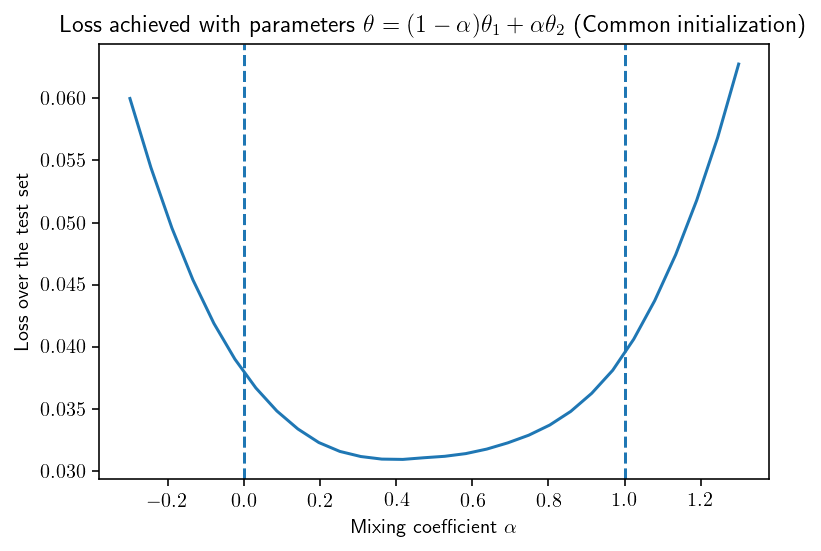

In [62]:
plt.figure()
plt.plot(alfas,losses)
plt.title(r"Loss achieved with parameters $\theta=(1-\alpha)\theta_1 + \alpha \theta_2$ (Common initialization)")
plt.ylabel("Loss over the test set");
plt.xlabel(r"Mixing coefficient $\alpha$");
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');

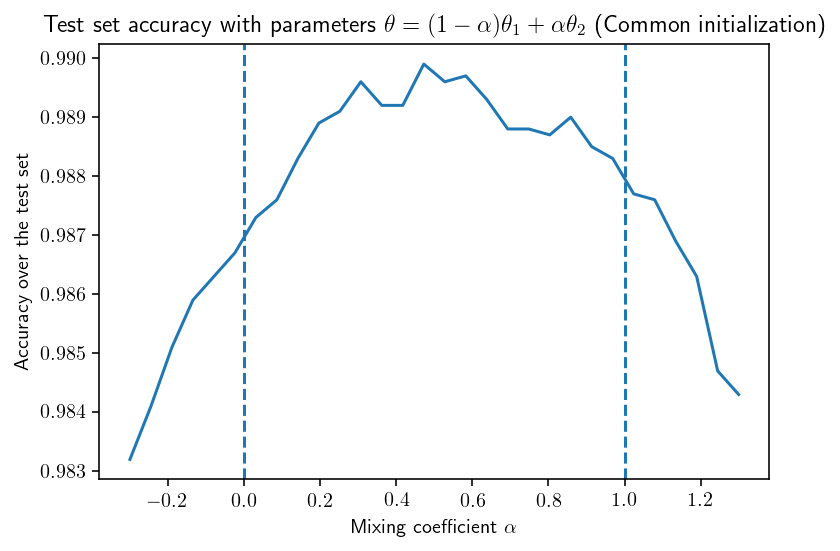

In [63]:
plt.figure()
plt.plot(alfas,accuracies)
plt.title(r"Test set accuracy with parameters $\theta=(1-\alpha)\theta_1 + \alpha \theta_2$ (Common initialization)")
plt.ylabel("Accuracy over the test set");
plt.xlabel(r"Mixing coefficient $\alpha$");
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');

# Experiment 1 and 3: Difference of the single model and mean model efficiency as n_learners grows

In [64]:
def test_model(theta):
    testmodel = Net()
    torch.nn.utils.vector_to_parameters(theta, testmodel.parameters())
    with torch.no_grad():
        return test(testmodel,dataset_test_loader)
    
def sizes(num,div):
    return [num // div + (1 if x < num % div else 0) for x in range(div)]

In [66]:
def test_n_learners(n_learners_list=[2], n_epochs_per_model=5, common_init=False, alfas = np.linspace(-0.2,1.2,20)):
    results = []
    for n_learners in n_learners_list:
        print("Starting the run with",n_learners,"learners")
        # divide the data evenly to n_learners
        dataset_sizes = sizes(60000, n_learners)
        datasets = torch.utils.data.random_split(dataset_train,dataset_sizes)

        dataloaders = [torch.utils.data.DataLoader(datasets[i], batch_size = 256) for i in range(n_learners)]
        testloader = torch.utils.data.DataLoader(dataset_test, batch_size = 256)

        # models
        models = [Net().to(DEVICE) for i in range(n_learners)]

        if common_init:
            # Copy everything from the model one
            init_theta = torch.nn.utils.parameters_to_vector(models[0].parameters())
            for i in range(1,n_learners):
                torch.nn.utils.vector_to_parameters(init_theta, models[i].parameters())

        # Train each model for n_epochs_per_model epochs
        for i in range(n_learners):
            print("Starting with learner",i)
            model = models[i]
            dataloader = dataloaders[i]
            optimizer = optim.Adam(model.parameters())
            for epoch in range(n_epochs_per_model):
                train(model, dataloader, optimizer, epoch)
                with torch.no_grad():
                    test(model, testloader)

        # set thetas
        thetas = [torch.nn.utils.parameters_to_vector(models[i].parameters()) for i in range(n_learners)]
        singletheta = thetas[0]
        meantheta = sum(thetas) / n_learners

        single_loss, single_acc = test_model(singletheta)
        mean_loss, mean_acc = test_model(meantheta)
        # quite slow, use sparingly
        losses = []
        accuracies = []
        for alfa in alfas:
            loss, acc = test_model(singletheta * (1-alfa) + meantheta * alfa)
            losses.append(loss)
            accuracies.append(acc)

        results.append((single_loss,single_acc,mean_loss,mean_acc, losses, accuracies, torch.linalg.norm(meantheta-singletheta)))
    return results

In [69]:
results = test_n_learners([1,2,5,10,20,50], 10, False)
single_losses = list(zip(*results))[0]
single_accuracies = list(zip(*results))[1]
mean_losses = list(zip(*results))[2]
mean_accuracies = list(zip(*results))[3]
loss_lists = list(zip(*results))[4]
acc_lists = list(zip(*results))[5]
theta_diffs = list(zip(*results))[6]

Starting the run with 1 learners
Starting with learner 0
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.298733
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.687022
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.466560
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.390926
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.287171
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.254595
Train Epoch: 0 [15360/60000 (26%)]	Loss: 0.203445
Train Epoch: 0 [17920/60000 (30%)]	Loss: 0.165800
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.204067
Train Epoch: 0 [23040/60000 (38%)]	Loss: 0.198449
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.185613
Train Epoch: 0 [28160/60000 (47%)]	Loss: 0.112560
Train Epoch: 0 [30720/60000 (51%)]	Loss: 0.130021
Train Epoch: 0 [33280/60000 (55%)]	Loss: 0.082014
Train Epoch: 0 [35840/60000 (60%)]	Loss: 0.100864
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.085180
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.160724
Train Epoch: 0 [43520/60000 (72%)]	Loss: 0.106505
Train Epoch: 0 [46080/60000 (77%)]	Loss: 0.145168
Tra

Train Epoch: 6 [33280/60000 (55%)]	Loss: 0.030494
Train Epoch: 6 [35840/60000 (60%)]	Loss: 0.028229
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.004472
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.037757
Train Epoch: 6 [43520/60000 (72%)]	Loss: 0.039425
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.030902
Train Epoch: 6 [48640/60000 (81%)]	Loss: 0.019368
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.009359
Train Epoch: 6 [53760/60000 (89%)]	Loss: 0.029421
Train Epoch: 6 [56320/60000 (94%)]	Loss: 0.038085
Train Epoch: 6 [58880/60000 (98%)]	Loss: 0.054956

Test set: Average loss: 0.0250, Accuracy: 9918/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.019733
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.067608
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.024390
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.011385
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.021625
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.027052
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.020100
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.047852

Train Epoch: 4 [23040/30000 (76%)]	Loss: 0.071263
Train Epoch: 4 [25600/30000 (85%)]	Loss: 0.045759
Train Epoch: 4 [28160/30000 (93%)]	Loss: 0.086687

Test set: Average loss: 0.0358, Accuracy: 9882/10000 (99%)

Train Epoch: 5 [0/30000 (0%)]	Loss: 0.024506
Train Epoch: 5 [2560/30000 (8%)]	Loss: 0.025801
Train Epoch: 5 [5120/30000 (17%)]	Loss: 0.026472
Train Epoch: 5 [7680/30000 (25%)]	Loss: 0.031160
Train Epoch: 5 [10240/30000 (34%)]	Loss: 0.056441
Train Epoch: 5 [12800/30000 (42%)]	Loss: 0.054729
Train Epoch: 5 [15360/30000 (51%)]	Loss: 0.051396
Train Epoch: 5 [17920/30000 (59%)]	Loss: 0.038241
Train Epoch: 5 [20480/30000 (68%)]	Loss: 0.050505
Train Epoch: 5 [23040/30000 (76%)]	Loss: 0.066361
Train Epoch: 5 [25600/30000 (85%)]	Loss: 0.036549
Train Epoch: 5 [28160/30000 (93%)]	Loss: 0.028013

Test set: Average loss: 0.0400, Accuracy: 9862/10000 (99%)

Train Epoch: 6 [0/30000 (0%)]	Loss: 0.040803
Train Epoch: 6 [2560/30000 (8%)]	Loss: 0.050043
Train Epoch: 6 [5120/30000 (17%)]	Loss: 0.03

Train Epoch: 7 [7680/30000 (25%)]	Loss: 0.038670
Train Epoch: 7 [10240/30000 (34%)]	Loss: 0.044372
Train Epoch: 7 [12800/30000 (42%)]	Loss: 0.033890
Train Epoch: 7 [15360/30000 (51%)]	Loss: 0.027187
Train Epoch: 7 [17920/30000 (59%)]	Loss: 0.020609
Train Epoch: 7 [20480/30000 (68%)]	Loss: 0.016968
Train Epoch: 7 [23040/30000 (76%)]	Loss: 0.044052
Train Epoch: 7 [25600/30000 (85%)]	Loss: 0.018978
Train Epoch: 7 [28160/30000 (93%)]	Loss: 0.047487

Test set: Average loss: 0.0379, Accuracy: 9884/10000 (99%)

Train Epoch: 8 [0/30000 (0%)]	Loss: 0.089971
Train Epoch: 8 [2560/30000 (8%)]	Loss: 0.031151
Train Epoch: 8 [5120/30000 (17%)]	Loss: 0.039587
Train Epoch: 8 [7680/30000 (25%)]	Loss: 0.051046
Train Epoch: 8 [10240/30000 (34%)]	Loss: 0.027852
Train Epoch: 8 [12800/30000 (42%)]	Loss: 0.020267
Train Epoch: 8 [15360/30000 (51%)]	Loss: 0.018211
Train Epoch: 8 [17920/30000 (59%)]	Loss: 0.028166
Train Epoch: 8 [20480/30000 (68%)]	Loss: 0.009154
Train Epoch: 8 [23040/30000 (76%)]	Loss: 0.021310

Train Epoch: 8 [7680/12000 (64%)]	Loss: 0.046084
Train Epoch: 8 [10240/12000 (85%)]	Loss: 0.042045

Test set: Average loss: 0.0557, Accuracy: 9835/10000 (98%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 0.025907
Train Epoch: 9 [2560/12000 (21%)]	Loss: 0.073719
Train Epoch: 9 [5120/12000 (43%)]	Loss: 0.039579
Train Epoch: 9 [7680/12000 (64%)]	Loss: 0.032846
Train Epoch: 9 [10240/12000 (85%)]	Loss: 0.026452

Test set: Average loss: 0.0515, Accuracy: 9852/10000 (99%)

Starting with learner 2
Train Epoch: 0 [0/12000 (0%)]	Loss: 2.287954
Train Epoch: 0 [2560/12000 (21%)]	Loss: 0.633067
Train Epoch: 0 [5120/12000 (43%)]	Loss: 0.494313
Train Epoch: 0 [7680/12000 (64%)]	Loss: 0.372661
Train Epoch: 0 [10240/12000 (85%)]	Loss: 0.347004

Test set: Average loss: 0.1733, Accuracy: 9477/10000 (95%)

Train Epoch: 1 [0/12000 (0%)]	Loss: 0.275629
Train Epoch: 1 [2560/12000 (21%)]	Loss: 0.163938
Train Epoch: 1 [5120/12000 (43%)]	Loss: 0.240713
Train Epoch: 1 [7680/12000 (64%)]	Loss: 0.220843
Train Epoch: 1 [10

Train Epoch: 5 [5120/12000 (43%)]	Loss: 0.066519
Train Epoch: 5 [7680/12000 (64%)]	Loss: 0.032314
Train Epoch: 5 [10240/12000 (85%)]	Loss: 0.077686

Test set: Average loss: 0.0578, Accuracy: 9809/10000 (98%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 0.104112
Train Epoch: 6 [2560/12000 (21%)]	Loss: 0.054787
Train Epoch: 6 [5120/12000 (43%)]	Loss: 0.055455
Train Epoch: 6 [7680/12000 (64%)]	Loss: 0.056853
Train Epoch: 6 [10240/12000 (85%)]	Loss: 0.057007

Test set: Average loss: 0.0557, Accuracy: 9814/10000 (98%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.080542
Train Epoch: 7 [2560/12000 (21%)]	Loss: 0.071140
Train Epoch: 7 [5120/12000 (43%)]	Loss: 0.056114
Train Epoch: 7 [7680/12000 (64%)]	Loss: 0.033339
Train Epoch: 7 [10240/12000 (85%)]	Loss: 0.066275

Test set: Average loss: 0.0542, Accuracy: 9826/10000 (98%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 0.052198
Train Epoch: 8 [2560/12000 (21%)]	Loss: 0.038913
Train Epoch: 8 [5120/12000 (43%)]	Loss: 0.067646
Train Epoch: 8 [7680/12000 (64%)]	Loss: 0.


Test set: Average loss: 0.0827, Accuracy: 9763/10000 (98%)

Starting with learner 3
Train Epoch: 0 [0/6000 (0%)]	Loss: 2.306688
Train Epoch: 0 [2560/6000 (42%)]	Loss: 0.704369
Train Epoch: 0 [5120/6000 (83%)]	Loss: 0.649118

Test set: Average loss: 0.3111, Accuracy: 9100/10000 (91%)

Train Epoch: 1 [0/6000 (0%)]	Loss: 0.398397
Train Epoch: 1 [2560/6000 (42%)]	Loss: 0.337208
Train Epoch: 1 [5120/6000 (83%)]	Loss: 0.334950

Test set: Average loss: 0.1894, Accuracy: 9416/10000 (94%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.269274
Train Epoch: 2 [2560/6000 (42%)]	Loss: 0.183686
Train Epoch: 2 [5120/6000 (83%)]	Loss: 0.276933

Test set: Average loss: 0.1298, Accuracy: 9562/10000 (96%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.170533
Train Epoch: 3 [2560/6000 (42%)]	Loss: 0.165937
Train Epoch: 3 [5120/6000 (83%)]	Loss: 0.246384

Test set: Average loss: 0.1041, Accuracy: 9674/10000 (97%)

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.139169
Train Epoch: 4 [2560/6000 (42%)]	Loss: 0.112745
Train Epoch: 4 [512

Train Epoch: 0 [2560/6000 (42%)]	Loss: 0.788649
Train Epoch: 0 [5120/6000 (83%)]	Loss: 0.569742

Test set: Average loss: 0.3392, Accuracy: 9050/10000 (90%)

Train Epoch: 1 [0/6000 (0%)]	Loss: 0.517570
Train Epoch: 1 [2560/6000 (42%)]	Loss: 0.364549
Train Epoch: 1 [5120/6000 (83%)]	Loss: 0.286106

Test set: Average loss: 0.2100, Accuracy: 9379/10000 (94%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.316853
Train Epoch: 2 [2560/6000 (42%)]	Loss: 0.340684
Train Epoch: 2 [5120/6000 (83%)]	Loss: 0.266894

Test set: Average loss: 0.1378, Accuracy: 9577/10000 (96%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.186876
Train Epoch: 3 [2560/6000 (42%)]	Loss: 0.254767
Train Epoch: 3 [5120/6000 (83%)]	Loss: 0.137056

Test set: Average loss: 0.1110, Accuracy: 9667/10000 (97%)

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.167805
Train Epoch: 4 [2560/6000 (42%)]	Loss: 0.168484
Train Epoch: 4 [5120/6000 (83%)]	Loss: 0.101273

Test set: Average loss: 0.0928, Accuracy: 9727/10000 (97%)

Train Epoch: 5 [0/6000 (0%)]	Loss: 0.11

Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.049505

Test set: Average loss: 0.1255, Accuracy: 9639/10000 (96%)

Starting with learner 1
Train Epoch: 0 [0/3000 (0%)]	Loss: 2.312179
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.985345

Test set: Average loss: 0.5295, Accuracy: 8452/10000 (85%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.657048
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.498976

Test set: Average loss: 0.3560, Accuracy: 8993/10000 (90%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.409098
Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.352359

Test set: Average loss: 0.2714, Accuracy: 9201/10000 (92%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.313348
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.310854

Test set: Average loss: 0.2008, Accuracy: 9408/10000 (94%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.267275
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.211037

Test set: Average loss: 0.1609, Accuracy: 9517/10000 (95%)

Train Epoch: 5 [0/3000 (0%)]	Loss: 0.178113
Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.168284

Test set:

Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.415238

Test set: Average loss: 0.2622, Accuracy: 9186/10000 (92%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.308842
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.271912

Test set: Average loss: 0.2029, Accuracy: 9396/10000 (94%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.188688
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.189898

Test set: Average loss: 0.1582, Accuracy: 9531/10000 (95%)

Train Epoch: 5 [0/3000 (0%)]	Loss: 0.152528
Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.176525

Test set: Average loss: 0.1467, Accuracy: 9541/10000 (95%)

Train Epoch: 6 [0/3000 (0%)]	Loss: 0.152219
Train Epoch: 6 [2560/3000 (83%)]	Loss: 0.171338

Test set: Average loss: 0.1345, Accuracy: 9572/10000 (96%)

Train Epoch: 7 [0/3000 (0%)]	Loss: 0.130458
Train Epoch: 7 [2560/3000 (83%)]	Loss: 0.082744

Test set: Average loss: 0.1245, Accuracy: 9625/10000 (96%)

Train Epoch: 8 [0/3000 (0%)]	Loss: 0.083891
Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.108247

Test set: Average loss: 0.1259, A

Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.166003

Test set: Average loss: 0.1227, Accuracy: 9637/10000 (96%)

Train Epoch: 6 [0/3000 (0%)]	Loss: 0.142614
Train Epoch: 6 [2560/3000 (83%)]	Loss: 0.139728

Test set: Average loss: 0.1198, Accuracy: 9647/10000 (96%)

Train Epoch: 7 [0/3000 (0%)]	Loss: 0.129632
Train Epoch: 7 [2560/3000 (83%)]	Loss: 0.106684

Test set: Average loss: 0.1193, Accuracy: 9636/10000 (96%)

Train Epoch: 8 [0/3000 (0%)]	Loss: 0.098127
Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.117346

Test set: Average loss: 0.1049, Accuracy: 9671/10000 (97%)

Train Epoch: 9 [0/3000 (0%)]	Loss: 0.109456
Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.084609

Test set: Average loss: 0.1078, Accuracy: 9654/10000 (97%)

Starting with learner 12
Train Epoch: 0 [0/3000 (0%)]	Loss: 2.312256
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.856227

Test set: Average loss: 0.4947, Accuracy: 8589/10000 (86%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.755999
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.505337

Test set

Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.058980

Test set: Average loss: 0.1106, Accuracy: 9657/10000 (97%)

Train Epoch: 9 [0/3000 (0%)]	Loss: 0.043219
Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.033014

Test set: Average loss: 0.1145, Accuracy: 9654/10000 (97%)

Starting with learner 17
Train Epoch: 0 [0/3000 (0%)]	Loss: 2.309210
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.915733

Test set: Average loss: 0.4806, Accuracy: 8515/10000 (85%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.689827
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.526892

Test set: Average loss: 0.3109, Accuracy: 9102/10000 (91%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.453383
Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.479928

Test set: Average loss: 0.2546, Accuracy: 9241/10000 (92%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.335931
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.332709

Test set: Average loss: 0.1921, Accuracy: 9399/10000 (94%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.217627
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.221368

Test set


Test set: Average loss: 0.3399, Accuracy: 9081/10000 (91%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.439158

Test set: Average loss: 0.3015, Accuracy: 9140/10000 (91%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.370545

Test set: Average loss: 0.2657, Accuracy: 9222/10000 (92%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.303202

Test set: Average loss: 0.2443, Accuracy: 9290/10000 (93%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.247878

Test set: Average loss: 0.2195, Accuracy: 9336/10000 (93%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.166445

Test set: Average loss: 0.2107, Accuracy: 9353/10000 (94%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.175402

Test set: Average loss: 0.1996, Accuracy: 9397/10000 (94%)

Starting with learner 3
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.293451

Test set: Average loss: 0.9743, Accuracy: 7903/10000 (79%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.124508

Test set: Average loss: 0.5311, Accuracy: 8242/10000 (82%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.610058

Test set: Average loss: 0.4293


Test set: Average loss: 1.2553, Accuracy: 7377/10000 (74%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.314965

Test set: Average loss: 0.6257, Accuracy: 8060/10000 (81%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.819637

Test set: Average loss: 0.4297, Accuracy: 8808/10000 (88%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.617282

Test set: Average loss: 0.3491, Accuracy: 9010/10000 (90%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.392693

Test set: Average loss: 0.3051, Accuracy: 9117/10000 (91%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.292724

Test set: Average loss: 0.2832, Accuracy: 9163/10000 (92%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.274426

Test set: Average loss: 0.2466, Accuracy: 9257/10000 (93%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.230717

Test set: Average loss: 0.2312, Accuracy: 9319/10000 (93%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.186570

Test set: Average loss: 0.2137, Accuracy: 9367/10000 (94%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.151533

Test set: Average loss: 0.2068, Accuracy: 9392/10000 (


Test set: Average loss: 0.2622, Accuracy: 9202/10000 (92%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.196269

Test set: Average loss: 0.2481, Accuracy: 9254/10000 (93%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.216849

Test set: Average loss: 0.2358, Accuracy: 9306/10000 (93%)

Starting with learner 18
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.305247

Test set: Average loss: 1.2026, Accuracy: 7629/10000 (76%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.284356

Test set: Average loss: 0.6106, Accuracy: 8257/10000 (83%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.782372

Test set: Average loss: 0.4573, Accuracy: 8639/10000 (86%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.545008

Test set: Average loss: 0.3858, Accuracy: 8889/10000 (89%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.417593

Test set: Average loss: 0.3434, Accuracy: 8997/10000 (90%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.321742

Test set: Average loss: 0.3188, Accuracy: 9063/10000 (91%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.277489

Test set: Average loss: 0.305


Test set: Average loss: 0.3661, Accuracy: 8951/10000 (90%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.352022

Test set: Average loss: 0.3188, Accuracy: 9082/10000 (91%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.297195

Test set: Average loss: 0.2955, Accuracy: 9136/10000 (91%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.226870

Test set: Average loss: 0.2853, Accuracy: 9176/10000 (92%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.194520

Test set: Average loss: 0.2592, Accuracy: 9258/10000 (93%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.197119

Test set: Average loss: 0.2458, Accuracy: 9274/10000 (93%)

Starting with learner 26
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.308734

Test set: Average loss: 1.2881, Accuracy: 7197/10000 (72%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.340151

Test set: Average loss: 0.6809, Accuracy: 7929/10000 (79%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.842313

Test set: Average loss: 0.5088, Accuracy: 8523/10000 (85%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.558881

Test set: Average loss: 0.397


Test set: Average loss: 0.5936, Accuracy: 8235/10000 (82%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.719327

Test set: Average loss: 0.4605, Accuracy: 8676/10000 (87%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.481319

Test set: Average loss: 0.3707, Accuracy: 8925/10000 (89%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.384832

Test set: Average loss: 0.3220, Accuracy: 9033/10000 (90%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.343822

Test set: Average loss: 0.3036, Accuracy: 9103/10000 (91%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.302476

Test set: Average loss: 0.2677, Accuracy: 9200/10000 (92%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.236909

Test set: Average loss: 0.2483, Accuracy: 9249/10000 (92%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.200653

Test set: Average loss: 0.2345, Accuracy: 9302/10000 (93%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.203653

Test set: Average loss: 0.2359, Accuracy: 9319/10000 (93%)

Starting with learner 34
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.306737

Test set: Average loss: 0.864


Test set: Average loss: 0.2595, Accuracy: 9206/10000 (92%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.221467

Test set: Average loss: 0.2396, Accuracy: 9278/10000 (93%)

Starting with learner 41
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.311032

Test set: Average loss: 1.0484, Accuracy: 7380/10000 (74%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.221880

Test set: Average loss: 0.6339, Accuracy: 7817/10000 (78%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.868350

Test set: Average loss: 0.4769, Accuracy: 8561/10000 (86%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.562522

Test set: Average loss: 0.3875, Accuracy: 8838/10000 (88%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.504521

Test set: Average loss: 0.3579, Accuracy: 8995/10000 (90%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.407729

Test set: Average loss: 0.3279, Accuracy: 9073/10000 (91%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.332780

Test set: Average loss: 0.3059, Accuracy: 9114/10000 (91%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.333565

Test set: Average loss: 0.275


Test set: Average loss: 0.2921, Accuracy: 9125/10000 (91%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.261120

Test set: Average loss: 0.2837, Accuracy: 9136/10000 (91%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.292657

Test set: Average loss: 0.2566, Accuracy: 9238/10000 (92%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.174771

Test set: Average loss: 0.2670, Accuracy: 9218/10000 (92%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.192033

Test set: Average loss: 0.2511, Accuracy: 9307/10000 (93%)

Starting with learner 49
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.308156

Test set: Average loss: 0.9933, Accuracy: 7313/10000 (73%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.207885

Test set: Average loss: 0.5791, Accuracy: 8234/10000 (82%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.811736

Test set: Average loss: 0.4337, Accuracy: 8705/10000 (87%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.556400

Test set: Average loss: 0.3835, Accuracy: 8876/10000 (89%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.473093

Test set: Average loss: 0.331

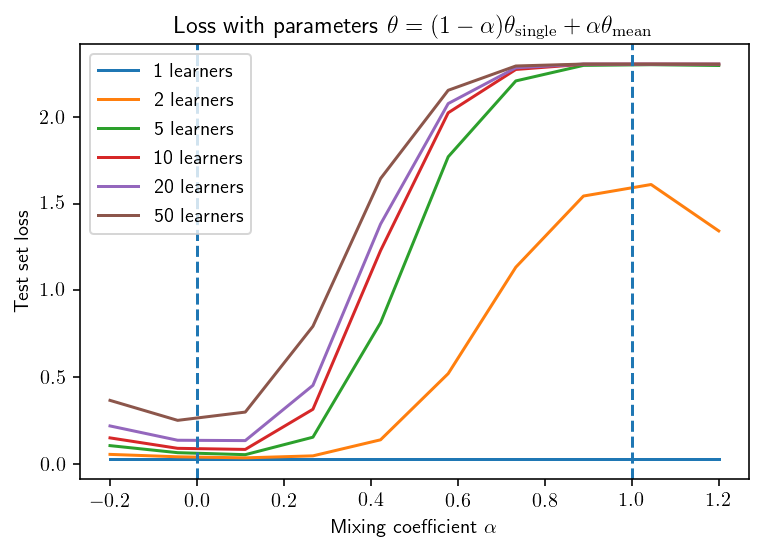

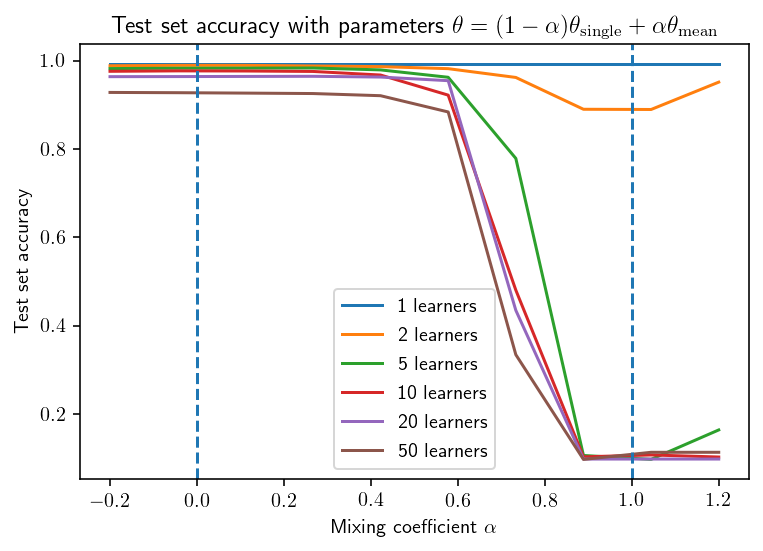

In [90]:
# Plot interesting plots with no common iniatalization
n_learners_list=[1,2,5,10,20,50]
alfas = np.linspace(-0.2,1.2,10)
plt.figure();
for index in range(len(n_learners_list)):
    plt.plot(alfas, loss_lists[index],label = str(n_learners_list[index])+" learners");
plt.legend()
plt.title(r"Loss with parameters $\theta = (1-\alpha )\theta_\mathrm{single} + \alpha \theta_\mathrm{mean}$")
plt.xlabel(r"Mixing coefficient $\alpha$")
plt.ylabel("Test set loss")
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');
plt.figure();
for index in range(len(n_learners_list)):
    plt.plot(alfas, acc_lists[index],label = str(n_learners_list[index])+" learners");
plt.title(r"Test set accuracy with parameters $\theta = (1-\alpha)\theta_\mathrm{single} + \alpha \theta_\mathrm{mean}$")
plt.xlabel(r"Mixing coefficient $\alpha$")
plt.ylabel("Test set accuracy")
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');
plt.legend()

In [93]:
# # Plot interesting plots WITH common iniatalization
n_learners_list=[1,2,5,10,20,50]
alfas = np.linspace(-0.2,1.2,10)
results = test_n_learners([1,2,5,10,20,50], 10, True)
single_losses = list(zip(*results))[0]
single_accuracies = list(zip(*results))[1]
mean_losses = list(zip(*results))[2]
mean_accuracies = list(zip(*results))[3]
loss_lists = list(zip(*results))[4]
acc_lists = list(zip(*results))[5]
theta_diffs = list(zip(*results))[6]

Starting the run with 1 learners
Starting with learner 0
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293400
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.771411
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.613786
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.465692
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.365927
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.354125
Train Epoch: 0 [15360/60000 (26%)]	Loss: 0.258011
Train Epoch: 0 [17920/60000 (30%)]	Loss: 0.183820
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.140943
Train Epoch: 0 [23040/60000 (38%)]	Loss: 0.283712
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.170326
Train Epoch: 0 [28160/60000 (47%)]	Loss: 0.197004
Train Epoch: 0 [30720/60000 (51%)]	Loss: 0.214573
Train Epoch: 0 [33280/60000 (55%)]	Loss: 0.182510
Train Epoch: 0 [35840/60000 (60%)]	Loss: 0.154154
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.114783
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.193398
Train Epoch: 0 [43520/60000 (72%)]	Loss: 0.119959
Train Epoch: 0 [46080/60000 (77%)]	Loss: 0.128921
Tra

Train Epoch: 6 [33280/60000 (55%)]	Loss: 0.054811
Train Epoch: 6 [35840/60000 (60%)]	Loss: 0.061587
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.023443
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.033907
Train Epoch: 6 [43520/60000 (72%)]	Loss: 0.010156
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.008772
Train Epoch: 6 [48640/60000 (81%)]	Loss: 0.038999
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.019009
Train Epoch: 6 [53760/60000 (89%)]	Loss: 0.026236
Train Epoch: 6 [56320/60000 (94%)]	Loss: 0.041870
Train Epoch: 6 [58880/60000 (98%)]	Loss: 0.021162

Test set: Average loss: 0.0284, Accuracy: 9917/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.023661
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.031177
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.042870
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.023071
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.021620
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.018875
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.099340
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.025387

Train Epoch: 4 [23040/30000 (76%)]	Loss: 0.024330
Train Epoch: 4 [25600/30000 (85%)]	Loss: 0.045908
Train Epoch: 4 [28160/30000 (93%)]	Loss: 0.060842

Test set: Average loss: 0.0507, Accuracy: 9839/10000 (98%)

Train Epoch: 5 [0/30000 (0%)]	Loss: 0.060552
Train Epoch: 5 [2560/30000 (8%)]	Loss: 0.044641
Train Epoch: 5 [5120/30000 (17%)]	Loss: 0.061462
Train Epoch: 5 [7680/30000 (25%)]	Loss: 0.098545
Train Epoch: 5 [10240/30000 (34%)]	Loss: 0.068468
Train Epoch: 5 [12800/30000 (42%)]	Loss: 0.035791
Train Epoch: 5 [15360/30000 (51%)]	Loss: 0.016552
Train Epoch: 5 [17920/30000 (59%)]	Loss: 0.027671
Train Epoch: 5 [20480/30000 (68%)]	Loss: 0.023545
Train Epoch: 5 [23040/30000 (76%)]	Loss: 0.033440
Train Epoch: 5 [25600/30000 (85%)]	Loss: 0.055354
Train Epoch: 5 [28160/30000 (93%)]	Loss: 0.048212

Test set: Average loss: 0.0395, Accuracy: 9881/10000 (99%)

Train Epoch: 6 [0/30000 (0%)]	Loss: 0.036988
Train Epoch: 6 [2560/30000 (8%)]	Loss: 0.035892
Train Epoch: 6 [5120/30000 (17%)]	Loss: 0.09

Train Epoch: 7 [7680/30000 (25%)]	Loss: 0.028716
Train Epoch: 7 [10240/30000 (34%)]	Loss: 0.055914
Train Epoch: 7 [12800/30000 (42%)]	Loss: 0.040982
Train Epoch: 7 [15360/30000 (51%)]	Loss: 0.038538
Train Epoch: 7 [17920/30000 (59%)]	Loss: 0.024968
Train Epoch: 7 [20480/30000 (68%)]	Loss: 0.024202
Train Epoch: 7 [23040/30000 (76%)]	Loss: 0.016819
Train Epoch: 7 [25600/30000 (85%)]	Loss: 0.021812
Train Epoch: 7 [28160/30000 (93%)]	Loss: 0.037073

Test set: Average loss: 0.0381, Accuracy: 9880/10000 (99%)

Train Epoch: 8 [0/30000 (0%)]	Loss: 0.019295
Train Epoch: 8 [2560/30000 (8%)]	Loss: 0.042707
Train Epoch: 8 [5120/30000 (17%)]	Loss: 0.080816
Train Epoch: 8 [7680/30000 (25%)]	Loss: 0.042249
Train Epoch: 8 [10240/30000 (34%)]	Loss: 0.047664
Train Epoch: 8 [12800/30000 (42%)]	Loss: 0.047381
Train Epoch: 8 [15360/30000 (51%)]	Loss: 0.031201
Train Epoch: 8 [17920/30000 (59%)]	Loss: 0.019978
Train Epoch: 8 [20480/30000 (68%)]	Loss: 0.033312
Train Epoch: 8 [23040/30000 (76%)]	Loss: 0.010994

Train Epoch: 8 [7680/12000 (64%)]	Loss: 0.028560
Train Epoch: 8 [10240/12000 (85%)]	Loss: 0.022708

Test set: Average loss: 0.0495, Accuracy: 9841/10000 (98%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 0.034089
Train Epoch: 9 [2560/12000 (21%)]	Loss: 0.059978
Train Epoch: 9 [5120/12000 (43%)]	Loss: 0.024039
Train Epoch: 9 [7680/12000 (64%)]	Loss: 0.026581
Train Epoch: 9 [10240/12000 (85%)]	Loss: 0.025399

Test set: Average loss: 0.0514, Accuracy: 9842/10000 (98%)

Starting with learner 2
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.091271
Train Epoch: 0 [2560/12000 (21%)]	Loss: 0.088904
Train Epoch: 0 [5120/12000 (43%)]	Loss: 0.121877
Train Epoch: 0 [7680/12000 (64%)]	Loss: 0.076721
Train Epoch: 0 [10240/12000 (85%)]	Loss: 0.073088

Test set: Average loss: 0.0442, Accuracy: 9857/10000 (99%)

Train Epoch: 1 [0/12000 (0%)]	Loss: 0.064514
Train Epoch: 1 [2560/12000 (21%)]	Loss: 0.062689
Train Epoch: 1 [5120/12000 (43%)]	Loss: 0.066967
Train Epoch: 1 [7680/12000 (64%)]	Loss: 0.033256
Train Epoch: 1 [10

Train Epoch: 5 [5120/12000 (43%)]	Loss: 0.018141
Train Epoch: 5 [7680/12000 (64%)]	Loss: 0.033601
Train Epoch: 5 [10240/12000 (85%)]	Loss: 0.063103

Test set: Average loss: 0.0389, Accuracy: 9894/10000 (99%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 0.007203
Train Epoch: 6 [2560/12000 (21%)]	Loss: 0.037305
Train Epoch: 6 [5120/12000 (43%)]	Loss: 0.021372
Train Epoch: 6 [7680/12000 (64%)]	Loss: 0.047934
Train Epoch: 6 [10240/12000 (85%)]	Loss: 0.047190

Test set: Average loss: 0.0391, Accuracy: 9887/10000 (99%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.015111
Train Epoch: 7 [2560/12000 (21%)]	Loss: 0.019233
Train Epoch: 7 [5120/12000 (43%)]	Loss: 0.007572
Train Epoch: 7 [7680/12000 (64%)]	Loss: 0.020970
Train Epoch: 7 [10240/12000 (85%)]	Loss: 0.015228

Test set: Average loss: 0.0359, Accuracy: 9904/10000 (99%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 0.021362
Train Epoch: 8 [2560/12000 (21%)]	Loss: 0.004576
Train Epoch: 8 [5120/12000 (43%)]	Loss: 0.020399
Train Epoch: 8 [7680/12000 (64%)]	Loss: 0.


Test set: Average loss: 0.0642, Accuracy: 9822/10000 (98%)

Starting with learner 3
Train Epoch: 0 [0/6000 (0%)]	Loss: 0.156923
Train Epoch: 0 [2560/6000 (42%)]	Loss: 0.037555
Train Epoch: 0 [5120/6000 (83%)]	Loss: 0.090892

Test set: Average loss: 0.0578, Accuracy: 9827/10000 (98%)

Train Epoch: 1 [0/6000 (0%)]	Loss: 0.059967
Train Epoch: 1 [2560/6000 (42%)]	Loss: 0.068196
Train Epoch: 1 [5120/6000 (83%)]	Loss: 0.118162

Test set: Average loss: 0.0580, Accuracy: 9831/10000 (98%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.064371
Train Epoch: 2 [2560/6000 (42%)]	Loss: 0.040111
Train Epoch: 2 [5120/6000 (83%)]	Loss: 0.043565

Test set: Average loss: 0.0533, Accuracy: 9856/10000 (99%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.024585
Train Epoch: 3 [2560/6000 (42%)]	Loss: 0.022305
Train Epoch: 3 [5120/6000 (83%)]	Loss: 0.048963

Test set: Average loss: 0.0549, Accuracy: 9844/10000 (98%)

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.030773
Train Epoch: 4 [2560/6000 (42%)]	Loss: 0.016317
Train Epoch: 4 [512

Train Epoch: 0 [2560/6000 (42%)]	Loss: 0.051281
Train Epoch: 0 [5120/6000 (83%)]	Loss: 0.084114

Test set: Average loss: 0.0351, Accuracy: 9883/10000 (99%)

Train Epoch: 1 [0/6000 (0%)]	Loss: 0.036947
Train Epoch: 1 [2560/6000 (42%)]	Loss: 0.098543
Train Epoch: 1 [5120/6000 (83%)]	Loss: 0.043203

Test set: Average loss: 0.0320, Accuracy: 9902/10000 (99%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.012270
Train Epoch: 2 [2560/6000 (42%)]	Loss: 0.093313
Train Epoch: 2 [5120/6000 (83%)]	Loss: 0.057412

Test set: Average loss: 0.0310, Accuracy: 9914/10000 (99%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.037588
Train Epoch: 3 [2560/6000 (42%)]	Loss: 0.004927
Train Epoch: 3 [5120/6000 (83%)]	Loss: 0.075199

Test set: Average loss: 0.0364, Accuracy: 9901/10000 (99%)

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.010827
Train Epoch: 4 [2560/6000 (42%)]	Loss: 0.016592
Train Epoch: 4 [5120/6000 (83%)]	Loss: 0.025347

Test set: Average loss: 0.0350, Accuracy: 9898/10000 (99%)

Train Epoch: 5 [0/6000 (0%)]	Loss: 0.01

Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.053239

Test set: Average loss: 0.1031, Accuracy: 9680/10000 (97%)

Starting with learner 1
Train Epoch: 0 [0/3000 (0%)]	Loss: 2.303741
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.698735

Test set: Average loss: 0.4609, Accuracy: 8654/10000 (87%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.717502
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.438762

Test set: Average loss: 0.2977, Accuracy: 9095/10000 (91%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.552032
Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.306115

Test set: Average loss: 0.2333, Accuracy: 9305/10000 (93%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.479080
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.258508

Test set: Average loss: 0.1929, Accuracy: 9416/10000 (94%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.310013
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.176100

Test set: Average loss: 0.1714, Accuracy: 9503/10000 (95%)

Train Epoch: 5 [0/3000 (0%)]	Loss: 0.253867
Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.139005

Test set:

Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.062964

Test set: Average loss: 0.0543, Accuracy: 9836/10000 (98%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.024449
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.032499

Test set: Average loss: 0.0580, Accuracy: 9829/10000 (98%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.021298
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.017499

Test set: Average loss: 0.0637, Accuracy: 9823/10000 (98%)

Train Epoch: 5 [0/3000 (0%)]	Loss: 0.009631
Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.006319

Test set: Average loss: 0.0664, Accuracy: 9831/10000 (98%)

Train Epoch: 6 [0/3000 (0%)]	Loss: 0.011169
Train Epoch: 6 [2560/3000 (83%)]	Loss: 0.009993

Test set: Average loss: 0.0636, Accuracy: 9837/10000 (98%)

Train Epoch: 7 [0/3000 (0%)]	Loss: 0.003296
Train Epoch: 7 [2560/3000 (83%)]	Loss: 0.004184

Test set: Average loss: 0.0646, Accuracy: 9830/10000 (98%)

Train Epoch: 8 [0/3000 (0%)]	Loss: 0.006020
Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.016082

Test set: Average loss: 0.0664, A

Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.012057

Test set: Average loss: 0.0472, Accuracy: 9874/10000 (99%)

Train Epoch: 6 [0/3000 (0%)]	Loss: 0.010563
Train Epoch: 6 [2560/3000 (83%)]	Loss: 0.025779

Test set: Average loss: 0.0509, Accuracy: 9878/10000 (99%)

Train Epoch: 7 [0/3000 (0%)]	Loss: 0.009510
Train Epoch: 7 [2560/3000 (83%)]	Loss: 0.004383

Test set: Average loss: 0.0494, Accuracy: 9874/10000 (99%)

Train Epoch: 8 [0/3000 (0%)]	Loss: 0.022749
Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.002613

Test set: Average loss: 0.0518, Accuracy: 9887/10000 (99%)

Train Epoch: 9 [0/3000 (0%)]	Loss: 0.020264
Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.000624

Test set: Average loss: 0.0509, Accuracy: 9870/10000 (99%)

Starting with learner 12
Train Epoch: 0 [0/3000 (0%)]	Loss: 0.183793
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.016455

Test set: Average loss: 0.0393, Accuracy: 9880/10000 (99%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.075365
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.047209

Test set

Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.002451

Test set: Average loss: 0.0408, Accuracy: 9898/10000 (99%)

Train Epoch: 9 [0/3000 (0%)]	Loss: 0.003205
Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.005031

Test set: Average loss: 0.0442, Accuracy: 9895/10000 (99%)

Starting with learner 17
Train Epoch: 0 [0/3000 (0%)]	Loss: 0.033886
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.069338

Test set: Average loss: 0.0376, Accuracy: 9887/10000 (99%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.040348
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.029480

Test set: Average loss: 0.0354, Accuracy: 9890/10000 (99%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.018086
Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.035789

Test set: Average loss: 0.0352, Accuracy: 9894/10000 (99%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.007452
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.041868

Test set: Average loss: 0.0362, Accuracy: 9896/10000 (99%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.019839
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.016238

Test set


Test set: Average loss: 0.1539, Accuracy: 9543/10000 (95%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.108258

Test set: Average loss: 0.1525, Accuracy: 9560/10000 (96%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.108708

Test set: Average loss: 0.1544, Accuracy: 9550/10000 (96%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.101612

Test set: Average loss: 0.1442, Accuracy: 9586/10000 (96%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.078000

Test set: Average loss: 0.1451, Accuracy: 9582/10000 (96%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.048449

Test set: Average loss: 0.1529, Accuracy: 9576/10000 (96%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.031462

Test set: Average loss: 0.1641, Accuracy: 9570/10000 (96%)

Starting with learner 3
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.126099

Test set: Average loss: 0.1324, Accuracy: 9603/10000 (96%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.106450

Test set: Average loss: 0.1178, Accuracy: 9652/10000 (97%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.084293

Test set: Average loss: 0.1088


Test set: Average loss: 0.0783, Accuracy: 9774/10000 (98%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.157856

Test set: Average loss: 0.0631, Accuracy: 9798/10000 (98%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.109836

Test set: Average loss: 0.0580, Accuracy: 9809/10000 (98%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.062855

Test set: Average loss: 0.0585, Accuracy: 9811/10000 (98%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.045656

Test set: Average loss: 0.0592, Accuracy: 9815/10000 (98%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.031233

Test set: Average loss: 0.0581, Accuracy: 9823/10000 (98%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.043585

Test set: Average loss: 0.0631, Accuracy: 9808/10000 (98%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.032594

Test set: Average loss: 0.0622, Accuracy: 9818/10000 (98%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.018908

Test set: Average loss: 0.0625, Accuracy: 9823/10000 (98%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.027923

Test set: Average loss: 0.0641, Accuracy: 9818/10000 (


Test set: Average loss: 0.0649, Accuracy: 9851/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.014400

Test set: Average loss: 0.0681, Accuracy: 9847/10000 (98%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.003306

Test set: Average loss: 0.0636, Accuracy: 9850/10000 (98%)

Starting with learner 18
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.200417

Test set: Average loss: 0.0553, Accuracy: 9832/10000 (98%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.058266

Test set: Average loss: 0.0585, Accuracy: 9840/10000 (98%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.074463

Test set: Average loss: 0.0524, Accuracy: 9846/10000 (98%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.043534

Test set: Average loss: 0.0526, Accuracy: 9845/10000 (98%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.036469

Test set: Average loss: 0.0533, Accuracy: 9860/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.012189

Test set: Average loss: 0.0549, Accuracy: 9855/10000 (99%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.066101

Test set: Average loss: 0.053


Test set: Average loss: 0.0619, Accuracy: 9856/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.003189

Test set: Average loss: 0.0650, Accuracy: 9849/10000 (98%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.018916

Test set: Average loss: 0.0631, Accuracy: 9856/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.014357

Test set: Average loss: 0.0572, Accuracy: 9858/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.017803

Test set: Average loss: 0.0540, Accuracy: 9862/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.014621

Test set: Average loss: 0.0567, Accuracy: 9862/10000 (99%)

Starting with learner 26
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.020423

Test set: Average loss: 0.0693, Accuracy: 9857/10000 (99%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.012906

Test set: Average loss: 0.0562, Accuracy: 9867/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.029342

Test set: Average loss: 0.0534, Accuracy: 9864/10000 (99%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.022655

Test set: Average loss: 0.054


Test set: Average loss: 0.0433, Accuracy: 9878/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.038788

Test set: Average loss: 0.0436, Accuracy: 9881/10000 (99%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.019479

Test set: Average loss: 0.0523, Accuracy: 9871/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.023340

Test set: Average loss: 0.0495, Accuracy: 9879/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.010673

Test set: Average loss: 0.0528, Accuracy: 9872/10000 (99%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.009758

Test set: Average loss: 0.0501, Accuracy: 9876/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.024634

Test set: Average loss: 0.0527, Accuracy: 9865/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.006208

Test set: Average loss: 0.0588, Accuracy: 9866/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.005204

Test set: Average loss: 0.0649, Accuracy: 9863/10000 (99%)

Starting with learner 34
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.149554

Test set: Average loss: 0.053


Test set: Average loss: 0.0559, Accuracy: 9867/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.041757

Test set: Average loss: 0.0572, Accuracy: 9863/10000 (99%)

Starting with learner 41
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.092330

Test set: Average loss: 0.0486, Accuracy: 9868/10000 (99%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.088649

Test set: Average loss: 0.0476, Accuracy: 9880/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.048912

Test set: Average loss: 0.0481, Accuracy: 9873/10000 (99%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.034809

Test set: Average loss: 0.0498, Accuracy: 9873/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.032711

Test set: Average loss: 0.0486, Accuracy: 9879/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.030223

Test set: Average loss: 0.0531, Accuracy: 9872/10000 (99%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.040535

Test set: Average loss: 0.0535, Accuracy: 9871/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.039157

Test set: Average loss: 0.047


Test set: Average loss: 0.0390, Accuracy: 9894/10000 (99%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.048743

Test set: Average loss: 0.0430, Accuracy: 9887/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.040473

Test set: Average loss: 0.0460, Accuracy: 9892/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.033267

Test set: Average loss: 0.0444, Accuracy: 9892/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.035075

Test set: Average loss: 0.0505, Accuracy: 9885/10000 (99%)

Starting with learner 49
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.327066

Test set: Average loss: 0.0409, Accuracy: 9879/10000 (99%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.064034

Test set: Average loss: 0.0420, Accuracy: 9891/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.070615

Test set: Average loss: 0.0433, Accuracy: 9885/10000 (99%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.054733

Test set: Average loss: 0.0419, Accuracy: 9891/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.040056

Test set: Average loss: 0.042

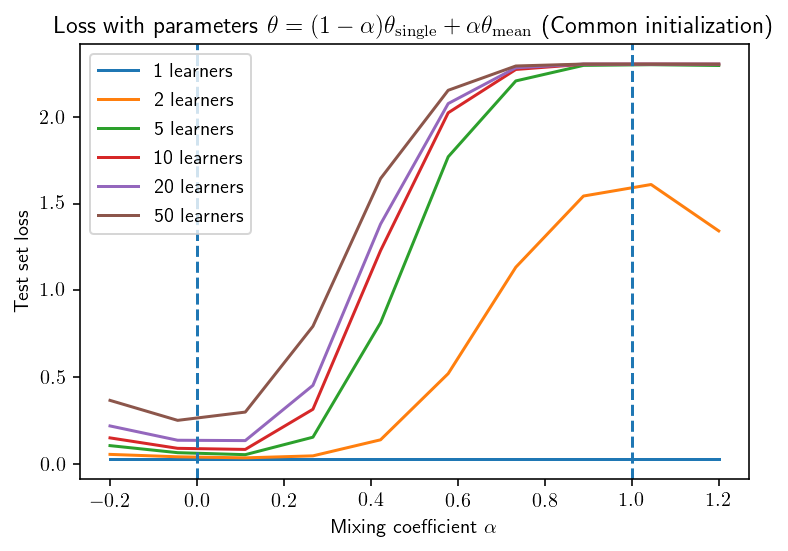

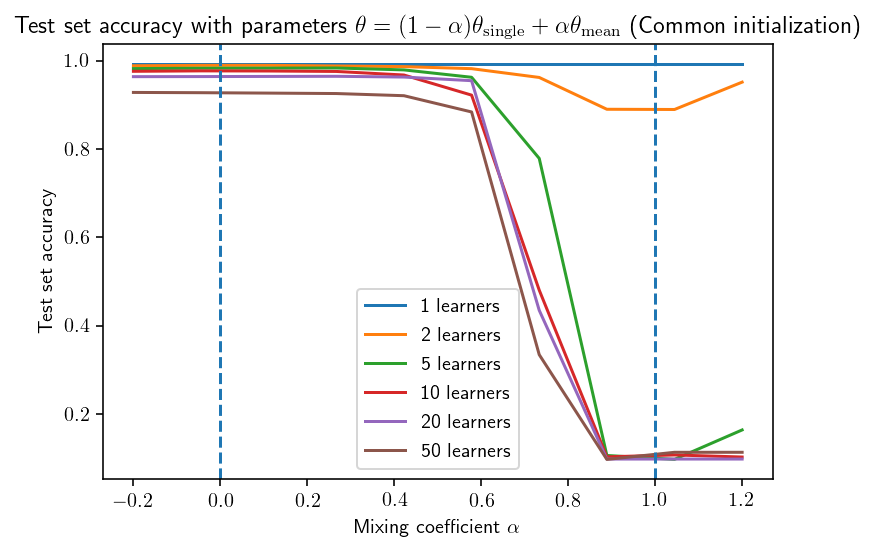

In [91]:
# Plot interesting plots with common iniatalization
n_learners_list=[1,2,5,10,20,50]
alfas = np.linspace(-0.2,1.2,10)
plt.figure();
for index in range(len(n_learners_list)):
    plt.plot(alfas, loss_lists[index],label = str(n_learners_list[index])+" learners");
plt.legend()
plt.title(r"Loss with parameters $\theta = (1-\alpha )\theta_\mathrm{single} + \alpha \theta_\mathrm{mean}$ (Common initialization)")
plt.xlabel(r"Mixing coefficient $\alpha$")
plt.ylabel("Test set loss")
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');
plt.figure();
for index in range(len(n_learners_list)):
    plt.plot(alfas, acc_lists[index],label = str(n_learners_list[index])+" learners");
plt.title(r"Test set accuracy with parameters $\theta = (1-\alpha)\theta_\mathrm{single} + \alpha \theta_\mathrm{mean}$ (Common initialization)")
plt.xlabel(r"Mixing coefficient $\alpha$")
plt.ylabel("Test set accuracy")
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');
plt.legend()

# Experiment 2: What if we do not take the mean of the whole models, but only first two layers?

In [66]:
def test_model(theta):
    testmodel = Net()
    torch.nn.utils.vector_to_parameters(theta, testmodel.parameters())
    with torch.no_grad():
        return test(testmodel,dataset_test_loader)
    
def sizes(num,div):
    return [num // div + (1 if x < num % div else 0) for x in range(div)]

def pi_1(tensor):
    mask = torch.cat([torch.ones(18816,device=DEVICE),torch.zeros(1181066,device=DEVICE)])
    return tensor * mask

def pi_2(tensor):
    mask = torch.cat([torch.zeros(18816,device=DEVICE),torch.ones(1181066,device=DEVICE)])
    return tensor * mask

In [83]:
def test_n_learners_early(n_learners_list=[2], n_epochs_per_model=10, common_init=False, alfas = np.linspace(-0.2,1.2,20)):
    results = []
    for n_learners in n_learners_list:
        print("Starting the run with",n_learners,"learners")
        # divide the data evenly to n_learners
        dataset_sizes = sizes(60000, n_learners)
        datasets = torch.utils.data.random_split(dataset_train,dataset_sizes)

        dataloaders = [torch.utils.data.DataLoader(datasets[i], batch_size = 256) for i in range(n_learners)]
        testloader = torch.utils.data.DataLoader(dataset_test, batch_size = 256)

        # models
        models = [Net().to(DEVICE) for i in range(n_learners)]

        if common_init:
            # Copy everything from the model one
            #init_theta = torch.nn.utils.parameters_to_vector(models[0].parameters())
            #for i in range(1,n_learners):
            #    torch.nn.utils.vector_to_parameters(init_theta, models[i].parameters())
            for i in range(1,n_learners):
                models[i].load_state_dict(models[0].state_dict())
                
    return dataloaders, testloader, models
        # Train each model for n_epochs_per_model epochs
        for i in range(n_learners):
            print("Starting with learner",i)
            model = models[i]
            dataloader = dataloaders[i]
            optimizer = optim.Adam(model.parameters())
            for epoch in range(n_epochs_per_model):
                train(model, dataloader, optimizer, epoch)
                with torch.no_grad():
                    test(model, testloader)

        # set thetas
        thetas = [torch.nn.utils.parameters_to_vector(models[i].parameters()) for i in range(n_learners)]
        theta1 = thetas[0]
        meantheta = sum(thetas) / n_learners
        theta1mean = pi_1(meantheta) + pi_2(theta1)

        single_loss, single_acc = test_model(theta1)
        mean_loss, mean_acc = test_model(theta1mean)
        # quite slow, use sparingly
        losses = []
        accuracies = []
        for alfa in alfas:
            loss, acc = test_model(theta1 * (1-alfa) + theta1mean * alfa)
            losses.append(loss)
            accuracies.append(acc)

        results.append((single_loss,single_acc,mean_loss,mean_acc, losses, accuracies, torch.linalg.norm(theta1mean-theta1)))
    return results

In [84]:
# run the function above, only sharing the first two layers (no common initialization)
n_learners_list=[1,2,5,10,20,50]
alfas = np.linspace(-0.2,1.2,10)
results = test_n_learners_early(n_learners_list, 10, True)
single_losses = list(zip(*results))[0]
single_accuracies = list(zip(*results))[1]
mean_losses = list(zip(*results))[2]
mean_accuracies = list(zip(*results))[3]
loss_lists = list(zip(*results))[4]
acc_lists = list(zip(*results))[5]
theta_diffs = list(zip(*results))[6]

Starting the run with 1 learners
Starting with learner 0
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.313930
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.750055
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.537075
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.509210
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.352747
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.322011
Train Epoch: 0 [15360/60000 (26%)]	Loss: 0.290249
Train Epoch: 0 [17920/60000 (30%)]	Loss: 0.257209
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.211020
Train Epoch: 0 [23040/60000 (38%)]	Loss: 0.270173
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.134104
Train Epoch: 0 [28160/60000 (47%)]	Loss: 0.126810
Train Epoch: 0 [30720/60000 (51%)]	Loss: 0.163890
Train Epoch: 0 [33280/60000 (55%)]	Loss: 0.148834
Train Epoch: 0 [35840/60000 (60%)]	Loss: 0.139651
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.134850
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.136910
Train Epoch: 0 [43520/60000 (72%)]	Loss: 0.135778
Train Epoch: 0 [46080/60000 (77%)]	Loss: 0.218616
Tra

Train Epoch: 6 [33280/60000 (55%)]	Loss: 0.018557
Train Epoch: 6 [35840/60000 (60%)]	Loss: 0.031581
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.060113
Train Epoch: 6 [40960/60000 (68%)]	Loss: 0.018535
Train Epoch: 6 [43520/60000 (72%)]	Loss: 0.012950
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.081593
Train Epoch: 6 [48640/60000 (81%)]	Loss: 0.032105
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.025334
Train Epoch: 6 [53760/60000 (89%)]	Loss: 0.015452
Train Epoch: 6 [56320/60000 (94%)]	Loss: 0.035738
Train Epoch: 6 [58880/60000 (98%)]	Loss: 0.012127

Test set: Average loss: 0.0304, Accuracy: 9911/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.028090
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.004048
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.008753
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.030594
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.014714
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.014263
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.037960
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.023297

Train Epoch: 3 [25600/30000 (85%)]	Loss: 0.143687
Train Epoch: 3 [28160/30000 (93%)]	Loss: 0.071275

Test set: Average loss: 0.0413, Accuracy: 9867/10000 (99%)

Train Epoch: 4 [0/30000 (0%)]	Loss: 0.072410
Train Epoch: 4 [2560/30000 (8%)]	Loss: 0.073494
Train Epoch: 4 [5120/30000 (17%)]	Loss: 0.051762
Train Epoch: 4 [7680/30000 (25%)]	Loss: 0.096959
Train Epoch: 4 [10240/30000 (34%)]	Loss: 0.023056
Train Epoch: 4 [12800/30000 (42%)]	Loss: 0.079411
Train Epoch: 4 [15360/30000 (51%)]	Loss: 0.053575
Train Epoch: 4 [17920/30000 (59%)]	Loss: 0.042370
Train Epoch: 4 [20480/30000 (68%)]	Loss: 0.027683
Train Epoch: 4 [23040/30000 (76%)]	Loss: 0.094915
Train Epoch: 4 [25600/30000 (85%)]	Loss: 0.115630
Train Epoch: 4 [28160/30000 (93%)]	Loss: 0.089979

Test set: Average loss: 0.0356, Accuracy: 9876/10000 (99%)

Train Epoch: 5 [0/30000 (0%)]	Loss: 0.059776
Train Epoch: 5 [2560/30000 (8%)]	Loss: 0.074821
Train Epoch: 5 [5120/30000 (17%)]	Loss: 0.076381
Train Epoch: 5 [7680/30000 (25%)]	Loss: 0.039

Train Epoch: 6 [10240/30000 (34%)]	Loss: 0.050296
Train Epoch: 6 [12800/30000 (42%)]	Loss: 0.025127
Train Epoch: 6 [15360/30000 (51%)]	Loss: 0.059257
Train Epoch: 6 [17920/30000 (59%)]	Loss: 0.031775
Train Epoch: 6 [20480/30000 (68%)]	Loss: 0.037097
Train Epoch: 6 [23040/30000 (76%)]	Loss: 0.080653
Train Epoch: 6 [25600/30000 (85%)]	Loss: 0.022390
Train Epoch: 6 [28160/30000 (93%)]	Loss: 0.040749

Test set: Average loss: 0.0374, Accuracy: 9877/10000 (99%)

Train Epoch: 7 [0/30000 (0%)]	Loss: 0.043721
Train Epoch: 7 [2560/30000 (8%)]	Loss: 0.065420
Train Epoch: 7 [5120/30000 (17%)]	Loss: 0.046227
Train Epoch: 7 [7680/30000 (25%)]	Loss: 0.071127
Train Epoch: 7 [10240/30000 (34%)]	Loss: 0.016456
Train Epoch: 7 [12800/30000 (42%)]	Loss: 0.034783
Train Epoch: 7 [15360/30000 (51%)]	Loss: 0.053421
Train Epoch: 7 [17920/30000 (59%)]	Loss: 0.045090
Train Epoch: 7 [20480/30000 (68%)]	Loss: 0.021502
Train Epoch: 7 [23040/30000 (76%)]	Loss: 0.054404
Train Epoch: 7 [25600/30000 (85%)]	Loss: 0.05592

Train Epoch: 4 [7680/12000 (64%)]	Loss: 0.067799
Train Epoch: 4 [10240/12000 (85%)]	Loss: 0.079175

Test set: Average loss: 0.0613, Accuracy: 9805/10000 (98%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 0.095538
Train Epoch: 5 [2560/12000 (21%)]	Loss: 0.057445
Train Epoch: 5 [5120/12000 (43%)]	Loss: 0.042127
Train Epoch: 5 [7680/12000 (64%)]	Loss: 0.051023
Train Epoch: 5 [10240/12000 (85%)]	Loss: 0.042551

Test set: Average loss: 0.0614, Accuracy: 9797/10000 (98%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 0.055353
Train Epoch: 6 [2560/12000 (21%)]	Loss: 0.072286
Train Epoch: 6 [5120/12000 (43%)]	Loss: 0.023788
Train Epoch: 6 [7680/12000 (64%)]	Loss: 0.084745
Train Epoch: 6 [10240/12000 (85%)]	Loss: 0.076159

Test set: Average loss: 0.0579, Accuracy: 9810/10000 (98%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.084680
Train Epoch: 7 [2560/12000 (21%)]	Loss: 0.034854
Train Epoch: 7 [5120/12000 (43%)]	Loss: 0.016949
Train Epoch: 7 [7680/12000 (64%)]	Loss: 0.055392
Train Epoch: 7 [10240/12000 (85%)]	Loss: 0

Train Epoch: 1 [5120/12000 (43%)]	Loss: 0.038259
Train Epoch: 1 [7680/12000 (64%)]	Loss: 0.023380
Train Epoch: 1 [10240/12000 (85%)]	Loss: 0.044336

Test set: Average loss: 0.0319, Accuracy: 9904/10000 (99%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 0.058274
Train Epoch: 2 [2560/12000 (21%)]	Loss: 0.037664
Train Epoch: 2 [5120/12000 (43%)]	Loss: 0.006675
Train Epoch: 2 [7680/12000 (64%)]	Loss: 0.021039
Train Epoch: 2 [10240/12000 (85%)]	Loss: 0.009677

Test set: Average loss: 0.0342, Accuracy: 9909/10000 (99%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 0.038332
Train Epoch: 3 [2560/12000 (21%)]	Loss: 0.019278
Train Epoch: 3 [5120/12000 (43%)]	Loss: 0.016081
Train Epoch: 3 [7680/12000 (64%)]	Loss: 0.017019
Train Epoch: 3 [10240/12000 (85%)]	Loss: 0.016944

Test set: Average loss: 0.0343, Accuracy: 9902/10000 (99%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 0.029635
Train Epoch: 4 [2560/12000 (21%)]	Loss: 0.070444
Train Epoch: 4 [5120/12000 (43%)]	Loss: 0.024793
Train Epoch: 4 [7680/12000 (64%)]	Loss: 0.

Train Epoch: 0 [5120/6000 (83%)]	Loss: 0.238921

Test set: Average loss: 0.0640, Accuracy: 9801/10000 (98%)

Train Epoch: 1 [0/6000 (0%)]	Loss: 0.077366
Train Epoch: 1 [2560/6000 (42%)]	Loss: 0.135015
Train Epoch: 1 [5120/6000 (83%)]	Loss: 0.092359

Test set: Average loss: 0.0635, Accuracy: 9796/10000 (98%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.060678
Train Epoch: 2 [2560/6000 (42%)]	Loss: 0.048983
Train Epoch: 2 [5120/6000 (83%)]	Loss: 0.056650

Test set: Average loss: 0.0590, Accuracy: 9819/10000 (98%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.037442
Train Epoch: 3 [2560/6000 (42%)]	Loss: 0.053844
Train Epoch: 3 [5120/6000 (83%)]	Loss: 0.091524

Test set: Average loss: 0.0578, Accuracy: 9817/10000 (98%)

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.039639
Train Epoch: 4 [2560/6000 (42%)]	Loss: 0.059930
Train Epoch: 4 [5120/6000 (83%)]	Loss: 0.079300

Test set: Average loss: 0.0574, Accuracy: 9832/10000 (98%)

Train Epoch: 5 [0/6000 (0%)]	Loss: 0.015236
Train Epoch: 5 [2560/6000 (42%)]	Loss: 0.05

Train Epoch: 1 [2560/6000 (42%)]	Loss: 0.039130
Train Epoch: 1 [5120/6000 (83%)]	Loss: 0.054619

Test set: Average loss: 0.0384, Accuracy: 9881/10000 (99%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 0.028427
Train Epoch: 2 [2560/6000 (42%)]	Loss: 0.030796
Train Epoch: 2 [5120/6000 (83%)]	Loss: 0.035330

Test set: Average loss: 0.0414, Accuracy: 9877/10000 (99%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 0.032938
Train Epoch: 3 [2560/6000 (42%)]	Loss: 0.019901
Train Epoch: 3 [5120/6000 (83%)]	Loss: 0.013031

Test set: Average loss: 0.0418, Accuracy: 9873/10000 (99%)

Train Epoch: 4 [0/6000 (0%)]	Loss: 0.027248
Train Epoch: 4 [2560/6000 (42%)]	Loss: 0.016622
Train Epoch: 4 [5120/6000 (83%)]	Loss: 0.050863

Test set: Average loss: 0.0426, Accuracy: 9870/10000 (99%)

Train Epoch: 5 [0/6000 (0%)]	Loss: 0.017725
Train Epoch: 5 [2560/6000 (42%)]	Loss: 0.015696
Train Epoch: 5 [5120/6000 (83%)]	Loss: 0.022336

Test set: Average loss: 0.0396, Accuracy: 9880/10000 (99%)

Train Epoch: 6 [0/6000 (0%)]	Loss: 0.01


Test set: Average loss: 0.0830, Accuracy: 9747/10000 (97%)


Test set: Average loss: 0.0798, Accuracy: 9750/10000 (98%)


Test set: Average loss: 0.0787, Accuracy: 9750/10000 (98%)


Test set: Average loss: 0.0796, Accuracy: 9753/10000 (98%)


Test set: Average loss: 0.0824, Accuracy: 9748/10000 (97%)


Test set: Average loss: 0.0872, Accuracy: 9745/10000 (97%)


Test set: Average loss: 0.0942, Accuracy: 9727/10000 (97%)


Test set: Average loss: 0.1036, Accuracy: 9715/10000 (97%)


Test set: Average loss: 0.1157, Accuracy: 9695/10000 (97%)


Test set: Average loss: 0.1309, Accuracy: 9660/10000 (97%)


Test set: Average loss: 0.1494, Accuracy: 9629/10000 (96%)


Test set: Average loss: 0.1716, Accuracy: 9584/10000 (96%)


Test set: Average loss: 0.1980, Accuracy: 9523/10000 (95%)


Test set: Average loss: 0.2297, Accuracy: 9442/10000 (94%)


Test set: Average loss: 0.2669, Accuracy: 9327/10000 (93%)


Test set: Average loss: 0.3102, Accuracy: 9183/10000 (92%)

Starting the run with 20

Train Epoch: 6 [2560/3000 (83%)]	Loss: 0.019601

Test set: Average loss: 0.0615, Accuracy: 9831/10000 (98%)

Train Epoch: 7 [0/3000 (0%)]	Loss: 0.018628
Train Epoch: 7 [2560/3000 (83%)]	Loss: 0.009118

Test set: Average loss: 0.0595, Accuracy: 9830/10000 (98%)

Train Epoch: 8 [0/3000 (0%)]	Loss: 0.022477
Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.023724

Test set: Average loss: 0.0657, Accuracy: 9828/10000 (98%)

Train Epoch: 9 [0/3000 (0%)]	Loss: 0.015876
Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.025729

Test set: Average loss: 0.0698, Accuracy: 9809/10000 (98%)

Starting with learner 5
Train Epoch: 0 [0/3000 (0%)]	Loss: 0.166183
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.136041

Test set: Average loss: 0.0510, Accuracy: 9835/10000 (98%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.099432
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.141077

Test set: Average loss: 0.0499, Accuracy: 9831/10000 (98%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.081314
Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.088469

Test set:

Train Epoch: 9 [2560/3000 (83%)]	Loss: 0.006117

Test set: Average loss: 0.0467, Accuracy: 9870/10000 (99%)

Starting with learner 10
Train Epoch: 0 [0/3000 (0%)]	Loss: 0.060220
Train Epoch: 0 [2560/3000 (83%)]	Loss: 0.117457

Test set: Average loss: 0.0491, Accuracy: 9844/10000 (98%)

Train Epoch: 1 [0/3000 (0%)]	Loss: 0.052591
Train Epoch: 1 [2560/3000 (83%)]	Loss: 0.067884

Test set: Average loss: 0.0414, Accuracy: 9869/10000 (99%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 0.029598
Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.019481

Test set: Average loss: 0.0478, Accuracy: 9856/10000 (99%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.023204
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.054981

Test set: Average loss: 0.0566, Accuracy: 9845/10000 (98%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.008263
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.039419

Test set: Average loss: 0.0550, Accuracy: 9855/10000 (99%)

Train Epoch: 5 [0/3000 (0%)]	Loss: 0.011065
Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.024100

Test set

Train Epoch: 2 [2560/3000 (83%)]	Loss: 0.066826

Test set: Average loss: 0.0419, Accuracy: 9878/10000 (99%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 0.011702
Train Epoch: 3 [2560/3000 (83%)]	Loss: 0.064450

Test set: Average loss: 0.0450, Accuracy: 9871/10000 (99%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 0.011836
Train Epoch: 4 [2560/3000 (83%)]	Loss: 0.028446

Test set: Average loss: 0.0533, Accuracy: 9869/10000 (99%)

Train Epoch: 5 [0/3000 (0%)]	Loss: 0.021029
Train Epoch: 5 [2560/3000 (83%)]	Loss: 0.032366

Test set: Average loss: 0.0431, Accuracy: 9884/10000 (99%)

Train Epoch: 6 [0/3000 (0%)]	Loss: 0.012049
Train Epoch: 6 [2560/3000 (83%)]	Loss: 0.035330

Test set: Average loss: 0.0465, Accuracy: 9877/10000 (99%)

Train Epoch: 7 [0/3000 (0%)]	Loss: 0.018467
Train Epoch: 7 [2560/3000 (83%)]	Loss: 0.048463

Test set: Average loss: 0.0439, Accuracy: 9881/10000 (99%)

Train Epoch: 8 [0/3000 (0%)]	Loss: 0.010362
Train Epoch: 8 [2560/3000 (83%)]	Loss: 0.032108

Test set: Average loss: 0.0464, A


Test set: Average loss: 0.3061, Accuracy: 9408/10000 (94%)


Test set: Average loss: 0.3745, Accuracy: 9285/10000 (93%)


Test set: Average loss: 0.4509, Accuracy: 9133/10000 (91%)


Test set: Average loss: 0.5326, Accuracy: 8920/10000 (89%)


Test set: Average loss: 0.6177, Accuracy: 8645/10000 (86%)


Test set: Average loss: 0.7042, Accuracy: 8316/10000 (83%)


Test set: Average loss: 0.7900, Accuracy: 7878/10000 (79%)


Test set: Average loss: 0.8735, Accuracy: 7479/10000 (75%)


Test set: Average loss: 0.9539, Accuracy: 7014/10000 (70%)

Starting the run with 50 learners
Starting with learner 0
Train Epoch: 0 [0/1200 (0%)]	Loss: 2.309677

Test set: Average loss: 1.0119, Accuracy: 7411/10000 (74%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 1.170635

Test set: Average loss: 0.5621, Accuracy: 8166/10000 (82%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.715198

Test set: Average loss: 0.4432, Accuracy: 8665/10000 (87%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.578818

Test set: Average loss: 0.4006, A


Test set: Average loss: 0.0745, Accuracy: 9775/10000 (98%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.113016

Test set: Average loss: 0.0762, Accuracy: 9766/10000 (98%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.069380

Test set: Average loss: 0.0742, Accuracy: 9791/10000 (98%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.071618

Test set: Average loss: 0.0783, Accuracy: 9788/10000 (98%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.058459

Test set: Average loss: 0.0803, Accuracy: 9772/10000 (98%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.028445

Test set: Average loss: 0.0910, Accuracy: 9756/10000 (98%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.023044

Test set: Average loss: 0.0874, Accuracy: 9754/10000 (98%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.026927

Test set: Average loss: 0.0892, Accuracy: 9747/10000 (97%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.022352

Test set: Average loss: 0.0900, Accuracy: 9751/10000 (98%)

Starting with learner 8
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.236737

Test set: Average loss: 0.0784


Test set: Average loss: 0.0602, Accuracy: 9840/10000 (98%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.004403

Test set: Average loss: 0.0653, Accuracy: 9831/10000 (98%)

Starting with learner 15
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.118705

Test set: Average loss: 0.0571, Accuracy: 9846/10000 (98%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.028587

Test set: Average loss: 0.0547, Accuracy: 9844/10000 (98%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.034189

Test set: Average loss: 0.0521, Accuracy: 9846/10000 (98%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.012741

Test set: Average loss: 0.0512, Accuracy: 9854/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.020134

Test set: Average loss: 0.0533, Accuracy: 9846/10000 (98%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.014113

Test set: Average loss: 0.0579, Accuracy: 9853/10000 (99%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.018693

Test set: Average loss: 0.0600, Accuracy: 9853/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.005329

Test set: Average loss: 0.061


Test set: Average loss: 0.0545, Accuracy: 9848/10000 (98%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.030824

Test set: Average loss: 0.0560, Accuracy: 9850/10000 (98%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.027477

Test set: Average loss: 0.0573, Accuracy: 9851/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.004734

Test set: Average loss: 0.0615, Accuracy: 9853/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.026883

Test set: Average loss: 0.0610, Accuracy: 9847/10000 (98%)

Starting with learner 23
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.104238

Test set: Average loss: 0.0507, Accuracy: 9847/10000 (98%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.039975

Test set: Average loss: 0.0502, Accuracy: 9854/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.027898

Test set: Average loss: 0.0496, Accuracy: 9849/10000 (98%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.044329

Test set: Average loss: 0.0501, Accuracy: 9856/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.022984

Test set: Average loss: 0.051


Test set: Average loss: 0.0570, Accuracy: 9846/10000 (98%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.014841

Test set: Average loss: 0.0565, Accuracy: 9861/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.030869

Test set: Average loss: 0.0560, Accuracy: 9862/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.073641

Test set: Average loss: 0.0582, Accuracy: 9842/10000 (98%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.012140

Test set: Average loss: 0.0609, Accuracy: 9831/10000 (98%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.008963

Test set: Average loss: 0.0577, Accuracy: 9861/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.035474

Test set: Average loss: 0.0597, Accuracy: 9853/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.009410

Test set: Average loss: 0.0630, Accuracy: 9851/10000 (99%)

Starting with learner 31
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.111432

Test set: Average loss: 0.0500, Accuracy: 9848/10000 (98%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.068180

Test set: Average loss: 0.048


Test set: Average loss: 0.0570, Accuracy: 9862/10000 (99%)

Starting with learner 38
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.064175

Test set: Average loss: 0.0478, Accuracy: 9860/10000 (99%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.044562

Test set: Average loss: 0.0456, Accuracy: 9856/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.069443

Test set: Average loss: 0.0492, Accuracy: 9856/10000 (99%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.062331

Test set: Average loss: 0.0482, Accuracy: 9855/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.044959

Test set: Average loss: 0.0474, Accuracy: 9857/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.021647

Test set: Average loss: 0.0504, Accuracy: 9854/10000 (99%)

Train Epoch: 6 [0/1200 (0%)]	Loss: 0.016157

Test set: Average loss: 0.0549, Accuracy: 9852/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.007617

Test set: Average loss: 0.0568, Accuracy: 9856/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.019719

Test set: Average loss: 0.055


Test set: Average loss: 0.0551, Accuracy: 9865/10000 (99%)

Train Epoch: 7 [0/1200 (0%)]	Loss: 0.009478

Test set: Average loss: 0.0558, Accuracy: 9873/10000 (99%)

Train Epoch: 8 [0/1200 (0%)]	Loss: 0.023134

Test set: Average loss: 0.0559, Accuracy: 9865/10000 (99%)

Train Epoch: 9 [0/1200 (0%)]	Loss: 0.017088

Test set: Average loss: 0.0582, Accuracy: 9869/10000 (99%)

Starting with learner 46
Train Epoch: 0 [0/1200 (0%)]	Loss: 0.080818

Test set: Average loss: 0.0468, Accuracy: 9873/10000 (99%)

Train Epoch: 1 [0/1200 (0%)]	Loss: 0.021471

Test set: Average loss: 0.0486, Accuracy: 9856/10000 (99%)

Train Epoch: 2 [0/1200 (0%)]	Loss: 0.057194

Test set: Average loss: 0.0470, Accuracy: 9864/10000 (99%)

Train Epoch: 3 [0/1200 (0%)]	Loss: 0.105670

Test set: Average loss: 0.0480, Accuracy: 9861/10000 (99%)

Train Epoch: 4 [0/1200 (0%)]	Loss: 0.026416

Test set: Average loss: 0.0502, Accuracy: 9870/10000 (99%)

Train Epoch: 5 [0/1200 (0%)]	Loss: 0.015249

Test set: Average loss: 0.050

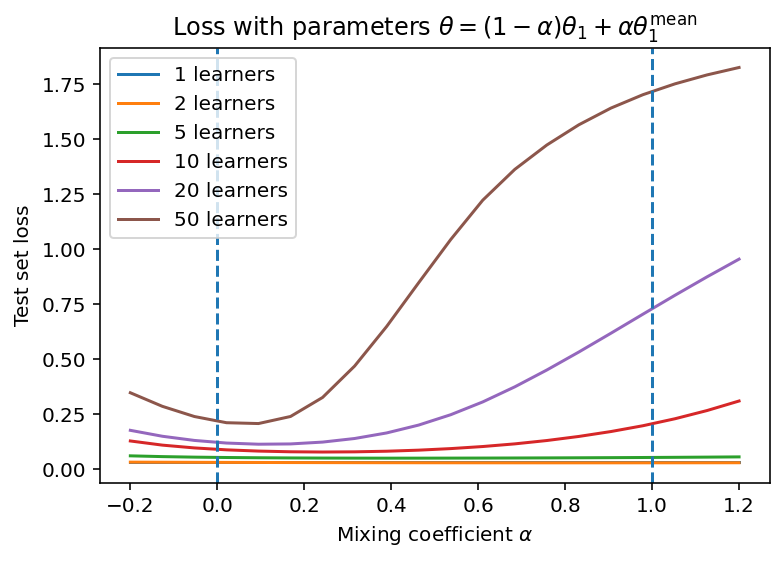

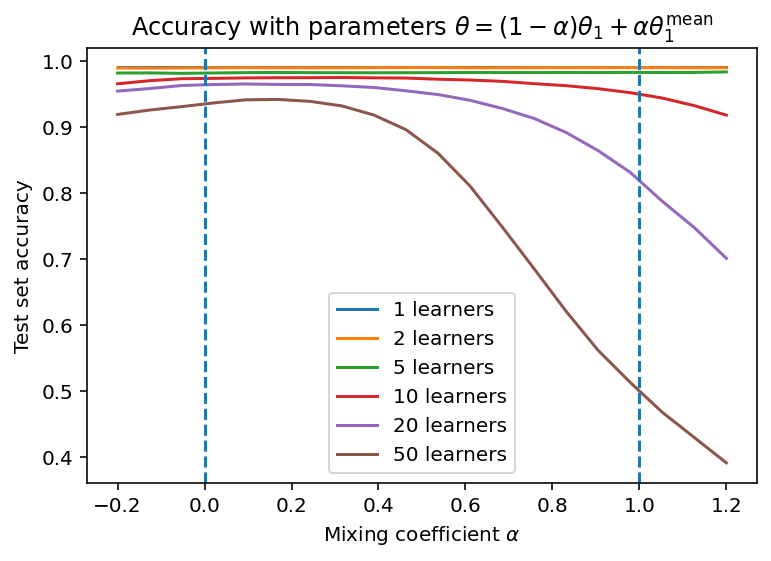

In [85]:
# Plot the plots for this experiment
alfas = np.linspace(-0.2,1.2,20)
plt.figure();
for index in range(len(n_learners_list)):
    plt.plot(alfas, loss_lists[index],label = str(n_learners_list[index])+" learners");
plt.legend()
plt.title(r"Loss with parameters $\theta = (1-\alpha )\theta_1 + \alpha \theta_1^\mathrm{mean}$")
plt.xlabel(r"Mixing coefficient $\alpha$")
plt.ylabel("Test set loss")
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');
plt.figure();
for index in range(len(n_learners_list)):
    plt.plot(alfas, acc_lists[index],label = str(n_learners_list[index])+" learners");
plt.title(r"Accuracy with parameters $\theta = (1-\alpha)\theta_1 + \alpha \theta_1^\mathrm{mean}$")
plt.xlabel(r"Mixing coefficient $\alpha$")
plt.ylabel("Test set accuracy")
plt.axvline(x=0,linestyle='--');
plt.axvline(x=1,linestyle='--');
plt.legend()